# Tumor Segmentation Demo
## BME 271D - Ege, Max, Sasha

**Two ways to use this:**
1. Click Runtime > Run All to analyze our sample tumors
2. OR upload your own tumor image below!

In [1]:
# Install packages
!pip install -q numpy matplotlib scipy scikit-image pandas

# Download our code from GitHub
!wget -q https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/tumor_segmentation.py
!wget -q https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/generate_realistic_tumors.py

# Download sample tumor images
!mkdir -p data/images data/masks
!wget -q -P data/images/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/images/tumor_001.png
!wget -q -P data/images/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/images/tumor_002.png
!wget -q -P data/images/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/images/tumor_003.png
!wget -q -P data/masks/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/masks/tumor_001.png
!wget -q -P data/masks/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/masks/tumor_002.png
!wget -q -P data/masks/ https://raw.githubusercontent.com/egeozemek/tumor-segmentation/main/data/masks/tumor_003.png

print('✅ Setup complete! Ready to analyze tumors.')

✅ Setup complete! Ready to analyze tumors.


In [4]:
import tumor_segmentation as ts
import matplotlib.pyplot as plt
from google.colab import files
import os
print('Ready!')

Ready!


## Option A: Upload Your Own Image (Optional)

**Want to analyze your own tumor image?** Run the cell below to upload!

In [8]:
# OPTIONAL: Upload your own tumor image (and optionally a mask)
print('🔹 Option 1: Upload ONLY a tumor image (no accuracy metrics)')
print('🔹 Option 2: Upload BOTH tumor image AND ground truth mask (get accuracy metrics!)\n')
print('Click "Choose Files" to upload 1 or 2 files:')
print('  IMPORTANT: Upload in this order:')
print('    1. FIRST: Tumor image (the grayscale scan)')
print('    2. SECOND: Mask (the black/white ground truth)\n')
print('Or skip this to use our sample images.\n')

uploaded = files.upload()

if uploaded:
    uploaded_files = list(uploaded.keys())

    if len(uploaded_files) == 1:
        # Only image, no mask
        custom_image_name = uploaded_files[0]
        custom_mask_name = None
        print(f'✅ Uploaded: {custom_image_name}')
        print('   (No mask uploaded - will show visual results only)')
    elif len(uploaded_files) == 2:
        # Try to detect which is image vs mask by checking if one is binary
        import numpy as np
        from PIL import Image as PILImage

        img1 = np.array(PILImage.open(uploaded_files[0]).convert('L'))
        img2 = np.array(PILImage.open(uploaded_files[1]).convert('L'))

        # Check which one is binary (mask) - has only 2 unique values
        unique1 = len(np.unique(img1))
        unique2 = len(np.unique(img2))

        if unique1 <= 3 and unique2 > 3:
            # First file is mask, second is image
            custom_image_name = uploaded_files[1]
            custom_mask_name = uploaded_files[0]
            print(f'✅ Detected IMAGE: {custom_image_name}')
            print(f'✅ Detected MASK: {custom_mask_name}')
        elif unique2 <= 3 and unique1 > 3:
            # Second file is mask, first is image
            custom_image_name = uploaded_files[0]
            custom_mask_name = uploaded_files[1]
            print(f'✅ Detected IMAGE: {custom_image_name}')
            print(f'✅ Detected MASK: {custom_mask_name}')
        else:
            # Can't tell - assume order
            custom_image_name = uploaded_files[0]
            custom_mask_name = uploaded_files[1]
            print(f'✅ Using first file as IMAGE: {custom_image_name}')
            print(f'✅ Using second file as MASK: {custom_mask_name}')

        print('   (Will calculate accuracy metrics!)')
    else:
        print('⚠️ Please upload 1 or 2 files only')
        custom_image_name = None
        custom_mask_name = None

    USE_CUSTOM = custom_image_name is not None
else:
    print('No file uploaded - will use sample images')
    USE_CUSTOM = False
    custom_mask_name = None

🔹 Option 1: Upload ONLY a tumor image (no accuracy metrics)
🔹 Option 2: Upload BOTH tumor image AND ground truth mask (get accuracy metrics!)

Click "Choose Files" to upload 1 or 2 files:
  IMPORTANT: Upload in this order:
    1. FIRST: Tumor image (the grayscale scan)
    2. SECOND: Mask (the black/white ground truth)

Or skip this to use our sample images.



Saving brain_tumor_006 copy.png to brain_tumor_006 copy (1).png
Saving brain_tumor_006.png to brain_tumor_006 (1).png
✅ Detected IMAGE: brain_tumor_006 (1).png
✅ Detected MASK: brain_tumor_006 copy (1).png
   (Will calculate accuracy metrics!)


## Option B: Use Our Sample Images

Choose which tumor to analyze (1, 2, or 3)

Analyzing your custom image with ground truth mask


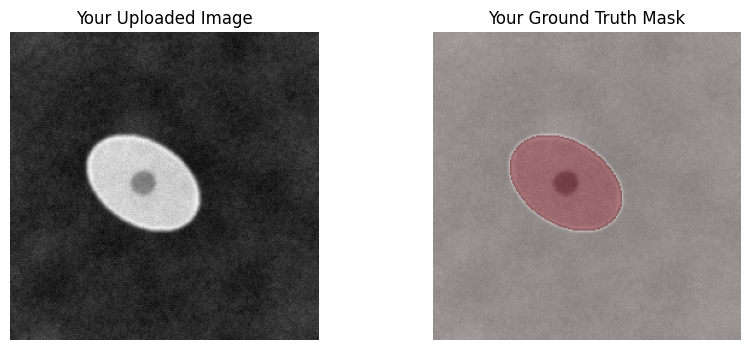

In [10]:
# Load image based on choice
if USE_CUSTOM:
    # Load the uploaded custom image
    image = ts.load_grayscale_image(custom_image_name)

    if custom_mask_name:
        # Load custom mask too!
        mask = ts.load_binary_mask(custom_mask_name)
        print(f'Analyzing your custom image with ground truth mask')
    else:
        mask = None  # No ground truth for custom images
        print(f'Analyzing your custom image: {custom_image_name}')

    # Display custom image
    if mask is not None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Your Uploaded Image')
        axes[0].axis('off')

        axes[1].imshow(image, cmap='gray')
        axes[1].imshow(mask, cmap='Reds', alpha=0.5)
        axes[1].set_title('Your Ground Truth Mask')
        axes[1].axis('off')
        plt.show()
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(image, cmap='gray')
        plt.title('Your Uploaded Tumor Image')
        plt.axis('off')
        plt.show()

else:
    # Use sample images
    tumor_number = 1  # Try 1, 2, or 3

    tumor_file = f'tumor_{tumor_number:03d}.png'
    print(f'Loading {tumor_file}...')

    image = ts.load_grayscale_image(f'data/images/{tumor_file}')
    mask = ts.load_binary_mask(f'data/masks/{tumor_file}')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title(f'Tumor Image {tumor_number}')
    axes[0].axis('off')

    axes[1].imshow(image, cmap='gray')
    axes[1].imshow(mask, cmap='Reds', alpha=0.5)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')
    plt.show()

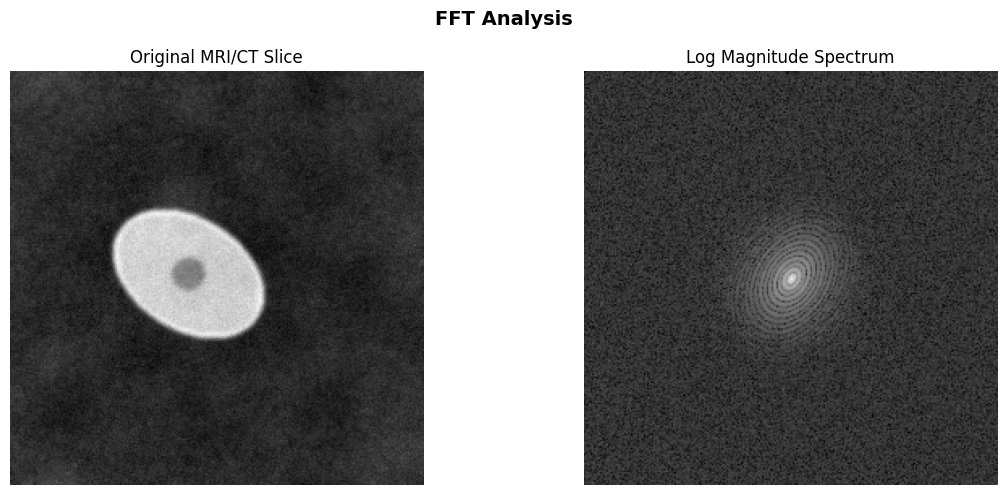

In [11]:
F_shift, mag = ts.compute_fft_spectrum(image)
fig = ts.visualize_frequency_spectrum(image, F_shift)
plt.show()

In [12]:
params = {'hp_radius': 25, 'bp_r1': 10, 'bp_r2': 40, 'canny_sigma': 1.0, 'gaussian_sigma': 1.0}

if mask is not None:
    # We have ground truth - calculate metrics
    results = ts.run_single_image_experiment(image, mask, params, verbose=True)

    print('\n=== RESULTS ===')
    for method, data in results.items():
        print(f"{method}: Dice = {data['metrics']['dice']:.3f}")
else:
    # Custom image - no ground truth, just show segmentations
    print('Running segmentation methods on your custom image...\n')

    # Run each method
    from skimage.filters import threshold_otsu
    from scipy import ndimage

    results = {}

    # Baseline Otsu
    thresh = threshold_otsu(image)
    results['Baseline_Raw_Otsu'] = {'mask': image < thresh}

    # Smoothed Otsu
    smoothed = ndimage.gaussian_filter(image, sigma=params['gaussian_sigma'])
    thresh = threshold_otsu(smoothed)
    results['Baseline_Smooth_Otsu'] = {'mask': smoothed < thresh}

    # FFT methods
    hp_img, _, _ = ts.filter_pipeline(image, 'hp', cutoff_radius=params['hp_radius'])
    thresh = threshold_otsu(hp_img)
    results['FFT_HighPass'] = {'mask': hp_img < thresh}

    bp_img, _, _ = ts.filter_pipeline(image, 'bp', r1=params['bp_r1'], r2=params['bp_r2'])
    thresh = threshold_otsu(bp_img)
    results['FFT_BandPass'] = {'mask': bp_img < thresh}

    # Canny
    results['Canny_Edges'] = {'mask': ts.canny_segmentation(image, sigma=params['canny_sigma'])}

    print('✅ Segmentation complete! (No accuracy metrics without ground truth)')

Running segmentation experiment...
  - Baseline 1: Raw Otsu...
  - Baseline 2: Smoothed Otsu...
  - FFT High-Pass...
  - FFT Band-Pass...
  - Canny Edge Detection...
Done!

=== RESULTS ===
Baseline_Raw_Otsu: Dice = 0.985
Baseline_Smooth_Otsu: Dice = 0.987
FFT_HighPass: Dice = 0.052
FFT_BandPass: Dice = 0.298
Canny_Edges: Dice = 0.950


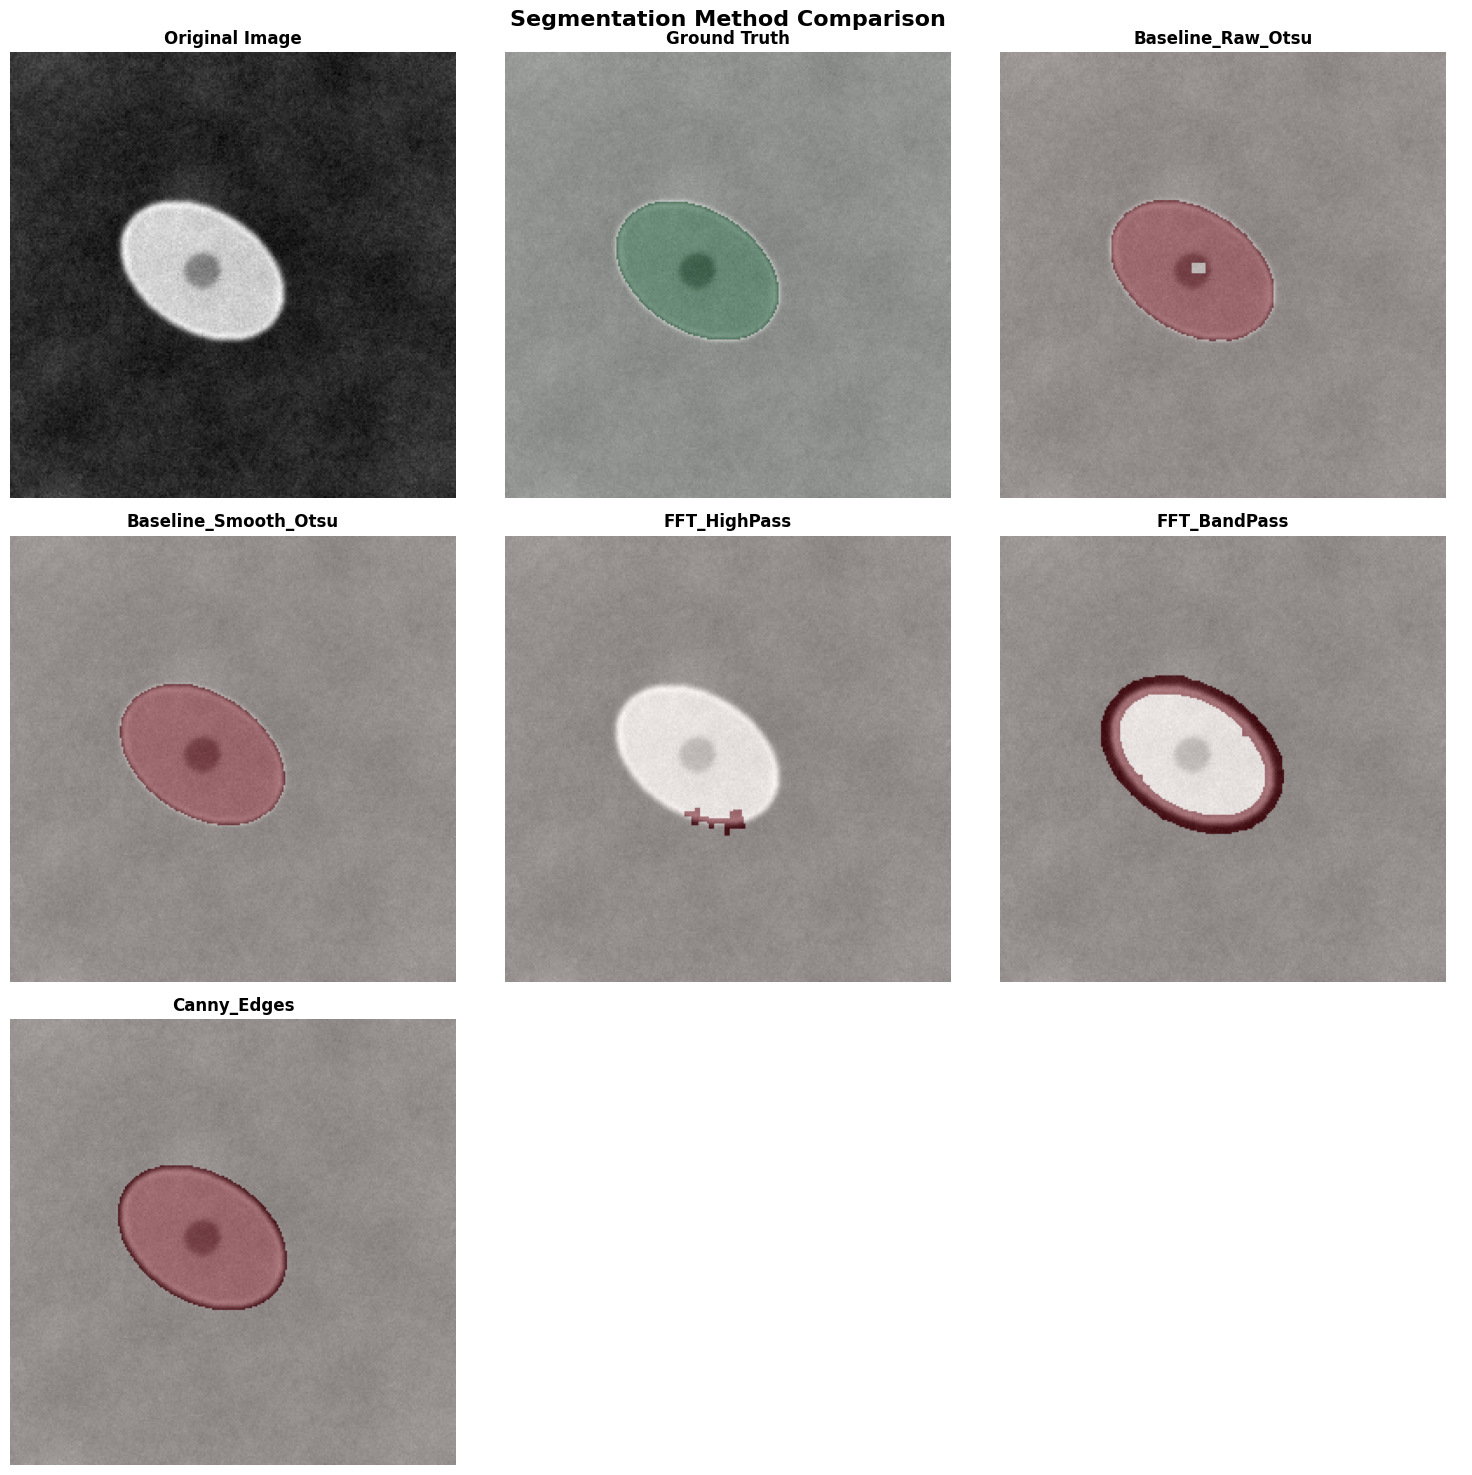

In [13]:
masks_dict = {name: data['mask'] for name, data in results.items()}

if mask is not None:
    # Show comparison with ground truth
    fig = ts.plot_segmentation_comparison(image, masks_dict, mask)
else:
    # Show just the segmentations without ground truth
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image', fontweight='bold')
    axes[0].axis('off')

    for idx, (method_name, data) in enumerate(masks_dict.items(), 1):
        axes[idx].imshow(image, cmap='gray')
        axes[idx].imshow(data, cmap='Reds', alpha=0.6)
        axes[idx].set_title(method_name, fontweight='bold')
        axes[idx].axis('off')

    plt.suptitle('Segmentation Method Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()

plt.show()

if mask is None:
    print('\n💡 Note: Without ground truth, we cannot calculate accuracy metrics.')
    print('   But you can visually compare which method found the tumor best!')